In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#model and tools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#metrics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

import warnings
warnings.filterwarnings("ignore")

# Data upload

In [2]:
orders = pd.read_csv('orders.csv')
orders.date = pd.to_datetime(orders.date)
orders.tail()

,delivery_area_id,date,orders_cnt
884851,592,2021-11-30 16:00:00,6
884852,592,2021-11-30 17:00:00,3
884853,592,2021-11-30 18:00:00,2
884854,592,2021-11-30 19:00:00,4
884855,592,2021-11-30 20:00:00,4


In [3]:
df_train = orders[(orders.date >= pd.to_datetime('2021-11-08')) & (orders.date < pd.to_datetime('2021-12-01'))]
df_train_const = df_train.groupby(by='delivery_area_id', as_index=False).mean()
df_train_const = df_train_const[df_train_const.orders_cnt >= 10]
df_train = df_train[df_train.delivery_area_id.isin(df_train_const.delivery_area_id)]

# Creating dataframe for prediction

In [4]:
df_pred = df_train[(df_train.date >= pd.to_datetime('2021-11-24')) & (df_train.date < pd.to_datetime('2021-12-01'))]
df_pred.date = df_pred.date + pd.Timedelta(1, unit='W')
df_pred.orders_cnt = int(0)
df_pred.tail()

,delivery_area_id,date,orders_cnt
802699,516,2021-12-07 17:00:00,0
802700,516,2021-12-07 18:00:00,0
802701,516,2021-12-07 19:00:00,0
802702,516,2021-12-07 20:00:00,0
802703,516,2021-12-07 21:00:00,0


# Number of orders forecasting

In [5]:
areas = df_train.delivery_area_id.unique()
areas

array([  0,   1,   4,   5,   8,   9,  10,  12,  14,  17,  19,  20,  21,
        23,  24,  25,  30,  33,  34,  36,  37,  38,  43,  46,  47,  48,
        49,  51,  52,  53,  56,  60,  61,  62,  65,  67,  68,  69,  70,
        87,  94,  95, 304, 419, 485, 516], dtype=int64)

In [6]:
for area in areas:
    df = df_train[df_train.delivery_area_id==area]
    x_train, y_train = df.date, df.orders_cnt
    df = df_pred[df_pred.delivery_area_id==area]
    x_test = df.date
    
    arima_model = ARIMA(y_train, order=(18, 0, 13))
    model = arima_model.fit()
    
    y_pred = model.predict(start=len(x_train), end=len(x_test)+len(x_train)-1)
    y_pred = y_pred.apply(int)
    y_pred.index = df.index
    #plt.plot(x_train, y_train)
    ##plt.plot(x_test, y_test)
    #plt.plot(x_test, y_pred)
    #plt.show()
    
    df.orders_cnt = y_pred
    df_pred[df_pred.delivery_area_id==area] = df
    #print(df_pred[df_pred.delivery_area_id==area])

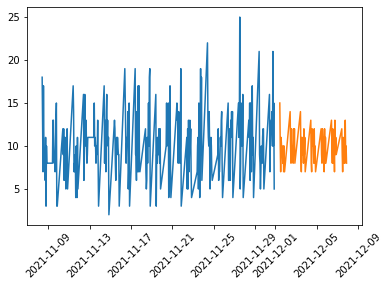

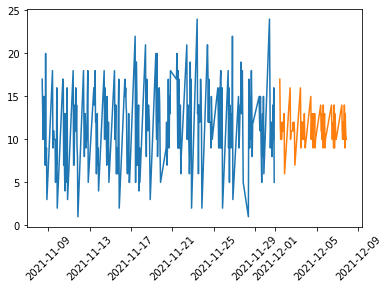

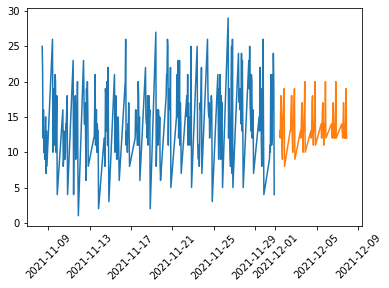

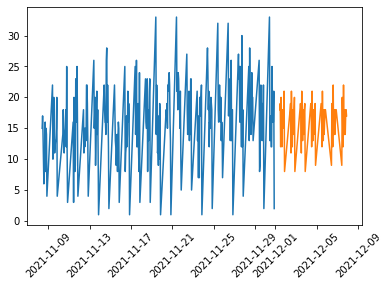

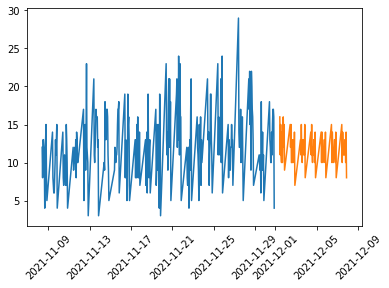

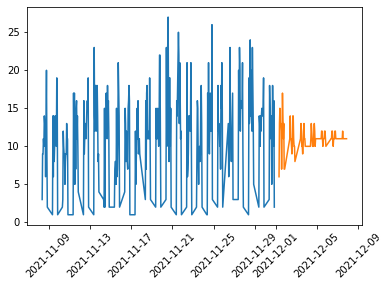

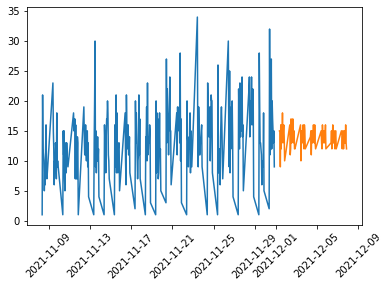

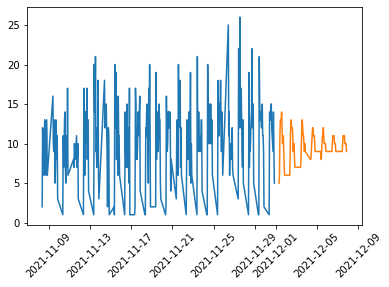

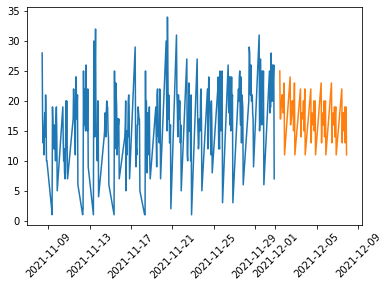

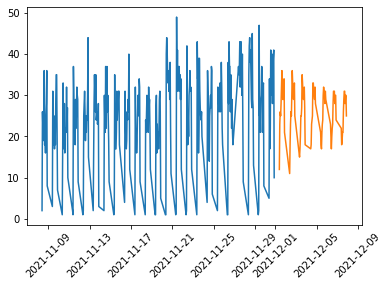

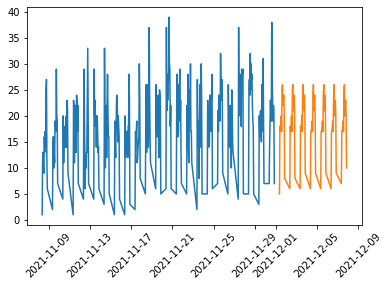

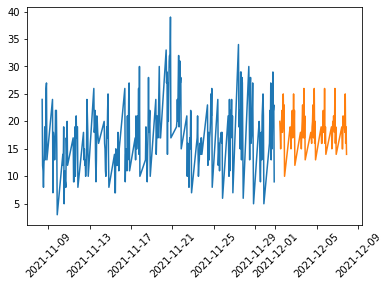

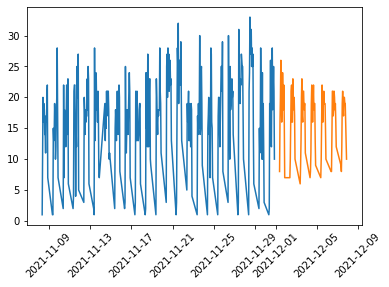

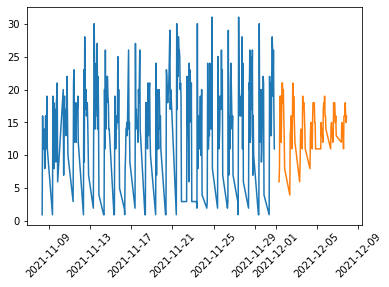

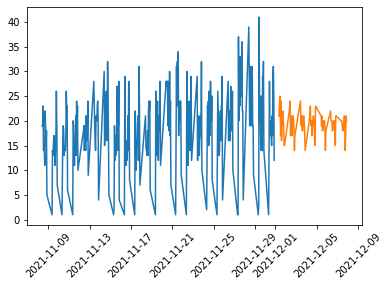

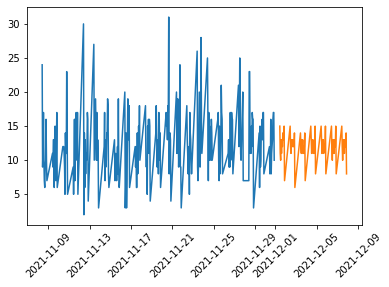

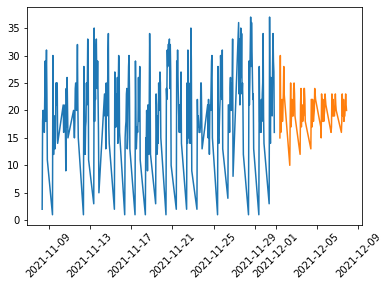

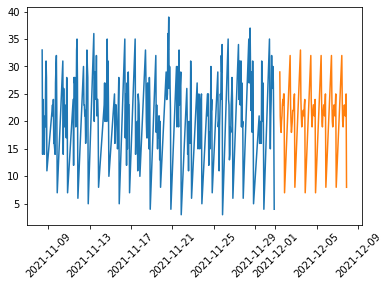

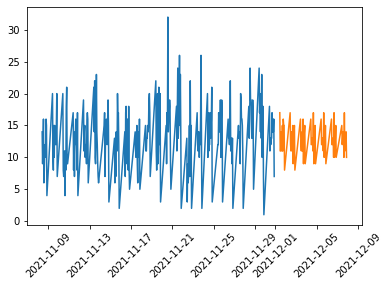

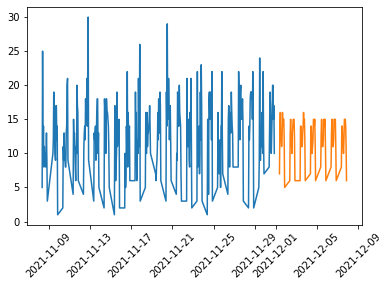

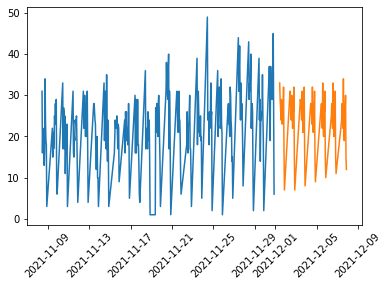

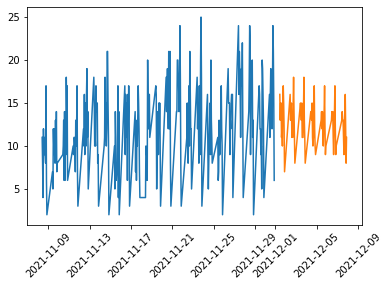

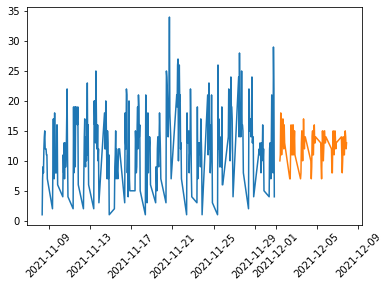

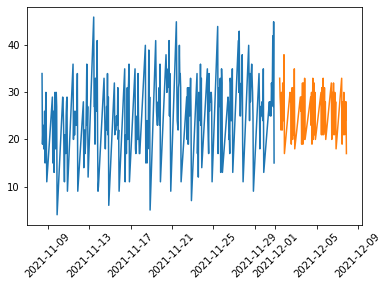

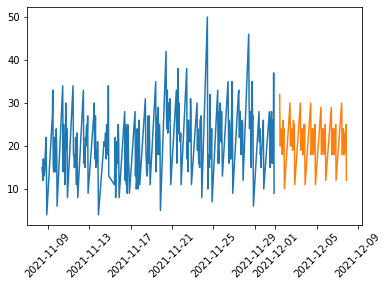

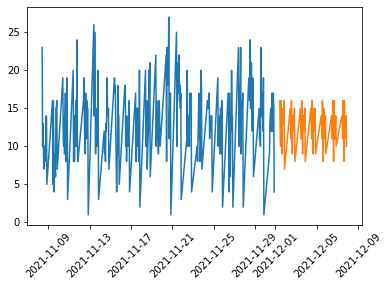

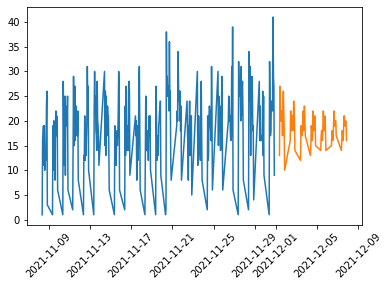

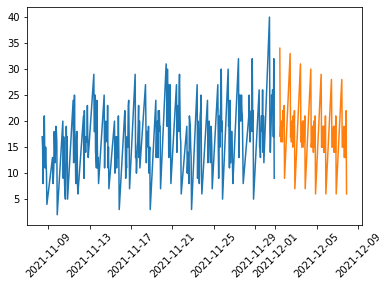

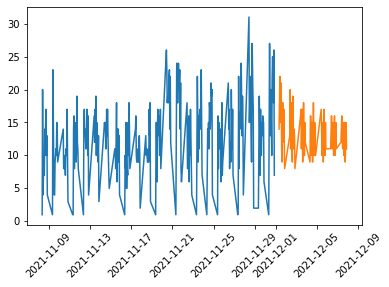

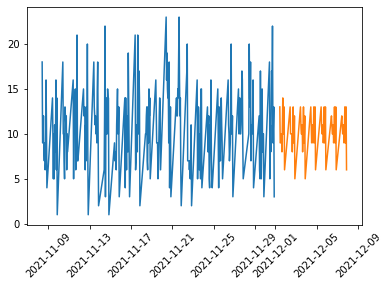

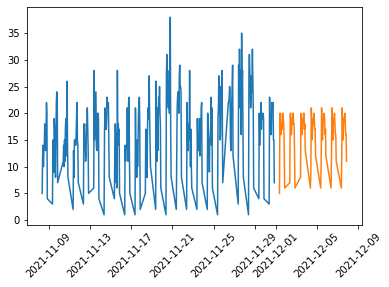

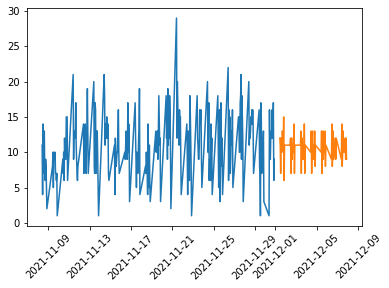

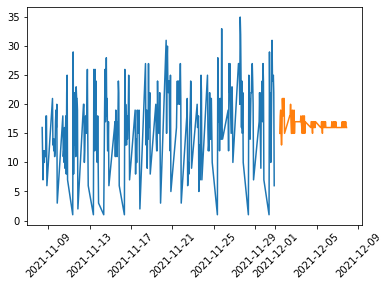

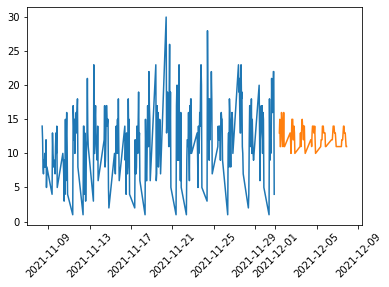

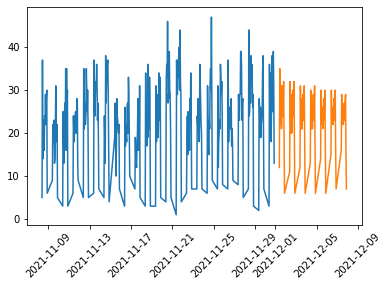

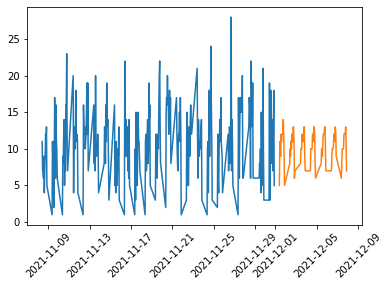

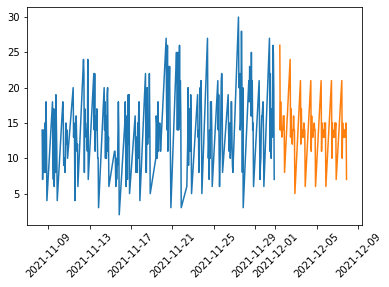

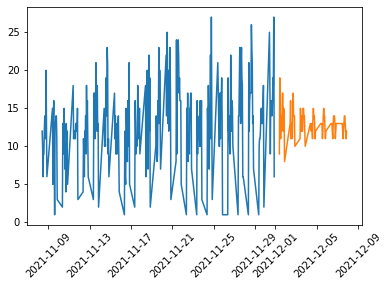

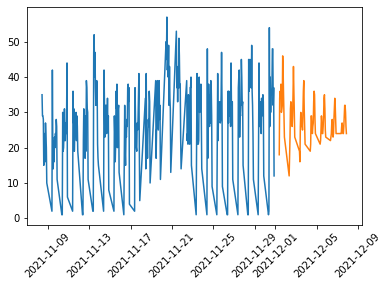

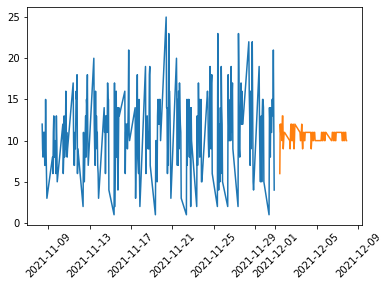

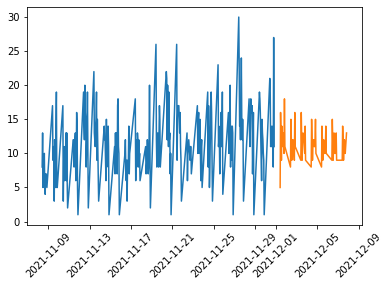

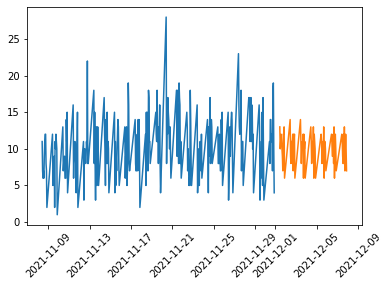

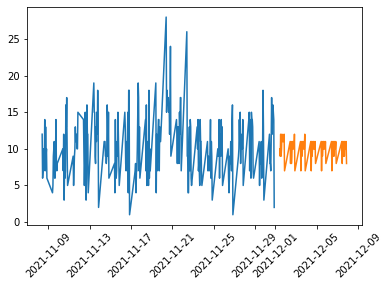

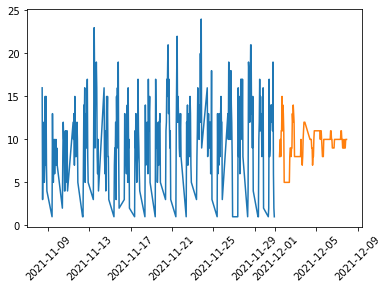

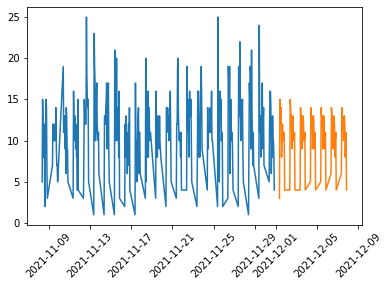

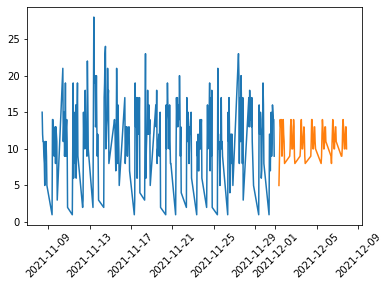

In [7]:
for area in areas:
    df = df_train[df_train.delivery_area_id==area]
    x_train, y_train = df.date, df.orders_cnt
    df = df_pred[df_pred.delivery_area_id==area]
    x_test, y_test = df.date, df.orders_cnt
    
    plt.plot(x_train, y_train)
    plt.plot(x_test, y_test)
    plt.xticks(rotation=45)
    plt.show()

# Export to .csv

In [8]:
df_pred.to_csv('orders-forecasted.csv', index=False)

In [9]:
tmp = pd.read_csv('orders-forecasted.csv')
tmp

,delivery_area_id,date,orders_cnt
0,0,2021-12-01 10:00:00,15
1,0,2021-12-01 11:00:00,10
2,0,2021-12-01 12:00:00,7
3,0,2021-12-01 13:00:00,11
4,0,2021-12-01 14:00:00,10
...,...,...,...
4008,516,2021-12-07 17:00:00,10
4009,516,2021-12-07 18:00:00,12
4010,516,2021-12-07 19:00:00,13
4011,516,2021-12-07 20:00:00,13
